In [17]:
# Initialisation de Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sum, max, min
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder \
    .appName("WaterConsumptionAnalysis") \
    .getOrCreate()

# Chargement des données
file_path = "cleaned_global_water_consumption.csv"
water_rdd = spark.sparkContext.textFile(file_path)

In [18]:
### Partie 1: Manipulation des RDD

# 1. Supprimer l'en-tête
header = water_rdd.first()
water_rdd = water_rdd.filter(lambda line: line != header)

In [19]:
# 2. Transformer les données
def parse_line(line):
    parts = line.split(";")
    return {
        "Country": parts[0],
        "Year": int(parts[1]),
        "Total_Water_Consumption": float(parts[2]),
        "Per_Capita_Water_Use": float(parts[3]),
        "Agricultural_Water_Use": float(parts[4]),
        "Industrial_Water_Use": float(parts[5]),
        "Household_Water_Use": float(parts[6]),
        "Rainfall_Impact": float(parts[7]),
        "Groundwater_Depletion_Rate": float(parts[8])
    }

parsed_rdd = water_rdd.map(parse_line)

In [20]:
# 3. Filtrer les valeurs nulles ou aberrantes
filtered_rdd = parsed_rdd.filter(
    lambda x: x["Total_Water_Consumption"] > 0 and 
    x["Per_Capita_Water_Use"] > 0 and
    x["Year"] >= 2000
)

# 4. Calculer la consommation totale par pays
total_consumption_rdd = filtered_rdd.map(
    lambda x: (x["Country"], x["Total_Water_Consumption"])
).reduceByKey(lambda a, b: a + b)

# 5. Trier par pays (ordre alphabétique)
sorted_rdd = total_consumption_rdd.sortByKey()

# Afficher les 5 premiers résultats
print("Consommation totale par pays (tri alphabétique):")
for country, consumption in sorted_rdd.take(5):
    print(f"{country}: {consumption:.2f} Billion Cubic Meters")

Consommation totale par pays (tri alphabétique):
Argentina: 13284.86 Billion Cubic Meters
Australia: 12505.78 Billion Cubic Meters
Brazil: 13263.29 Billion Cubic Meters
Canada: 12352.69 Billion Cubic Meters
China: 13133.60 Billion Cubic Meters


In [21]:
### Partie 2: Utilisation de Spark SQL

# Création du DataFrame
water_df = spark.createDataFrame(filtered_rdd)
water_df.createOrReplaceTempView("water_consumption")

# Requête 1: Top 5 pays avec la plus grande consommation totale
top5_countries = spark.sql("""
    SELECT Country, SUM(Total_Water_Consumption) as Total_Consumption
    FROM water_consumption
    GROUP BY Country
    ORDER BY Total_Consumption DESC
    LIMIT 5
""")
print("\nTop 5 pays avec la plus grande consommation totale:")
top5_countries.show()


Top 5 pays avec la plus grande consommation totale:
+------------+------------------+
|     Country| Total_Consumption|
+------------+------------------+
|   Argentina|13284.860759399999|
|      Brazil|     13263.2874357|
|       China|13133.596733100001|
|         USA|13058.950844299996|
|Saudi Arabia|     12966.0786791|
+------------+------------------+



In [22]:
# Requête 2: Pays avec la plus grande consommation par habitant
max_per_capita = spark.sql("""
    SELECT Country, Year, Per_Capita_Water_Use
    FROM water_consumption
    ORDER BY Per_Capita_Water_Use DESC
    LIMIT 1
""")
print("\nPays avec la plus grande consommation par habitant:")
max_per_capita.show()


Pays avec la plus grande consommation par habitant:
+-------+----+--------------------+
|Country|Year|Per_Capita_Water_Use|
+-------+----+--------------------+
|  India|2000|              404.35|
+-------+----+--------------------+



In [23]:
# Requête 3: Année avec consommation maximale et minimale
yearly_consumption = spark.sql("""
    SELECT Year, 
           SUM(Total_Water_Consumption) as Global_Consumption
    FROM water_consumption
    GROUP BY Year
    ORDER BY Global_Consumption
""")
min_year = yearly_consumption.first()
max_year = yearly_consumption.orderBy(col("Global_Consumption").desc()).first()

print(f"\nAnnée avec consommation minimale: {min_year['Year']} ({min_year['Global_Consumption']:.2f} BCM)")
print(f"Année avec consommation maximale: {max_year['Year']} ({max_year['Global_Consumption']:.2f} BCM)")


Année avec consommation minimale: 2005 (9124.76 BCM)
Année avec consommation maximale: 2008 (11062.78 BCM)


In [24]:
# Requête 4: Consommation moyenne par habitant par pays
avg_per_capita = spark.sql("""
    SELECT Country, AVG(Per_Capita_Water_Use) as Avg_Per_Capita
    FROM water_consumption
    GROUP BY Country
    ORDER BY Avg_Per_Capita DESC
""")
print("\nConsommation moyenne par habitant par pays (top 5):")
avg_per_capita.show(5)


Consommation moyenne par habitant par pays (top 5):
+-------+------------------+
|Country|    Avg_Per_Capita|
+-------+------------------+
|  India|295.16806734000005|
|  Italy|284.19626263600003|
| Turkey|     281.703477536|
|     UK|280.99844273599996|
| Russia|         280.95933|
+-------+------------------+
only showing top 5 rows



In [25]:
# Requête 5: Impact des précipitations
rainfall_impact = spark.sql("""
    SELECT 
        CASE 
            WHEN Rainfall_Impact < 1000 THEN 'Faible'
            WHEN Rainfall_Impact BETWEEN 1000 AND 2000 THEN 'Moyenne'
            ELSE 'Élevée'
        END as Rainfall_Category,
        AVG(Total_Water_Consumption) as Avg_Consumption,
        AVG(Agricultural_Water_Use) as Avg_Agri_Use
    FROM water_consumption
    GROUP BY Rainfall_Category
    ORDER BY Avg_Consumption DESC
""")
print("\nImpact des précipitations sur la consommation:")
rainfall_impact.show()


Impact des précipitations sur la consommation:
+-----------------+------------------+------------------+
|Rainfall_Category|   Avg_Consumption|      Avg_Agri_Use|
+-----------------+------------------+------------------+
|           Faible|   518.44910450625|48.655208987500004|
|          Moyenne| 500.7864862414254|50.144501095456576|
|           Élevée|498.96848844571434| 51.34429620657142|
+-----------------+------------------+------------------+



In [26]:
### Partie 3: Visualisation des résultats

# Convertir les DataFrames Spark en Pandas pour visualisation
top5_pd = top5_countries.toPandas()
avg_per_capita_pd = avg_per_capita.limit(10).toPandas()
yearly_consumption_pd = yearly_consumption.toPandas()

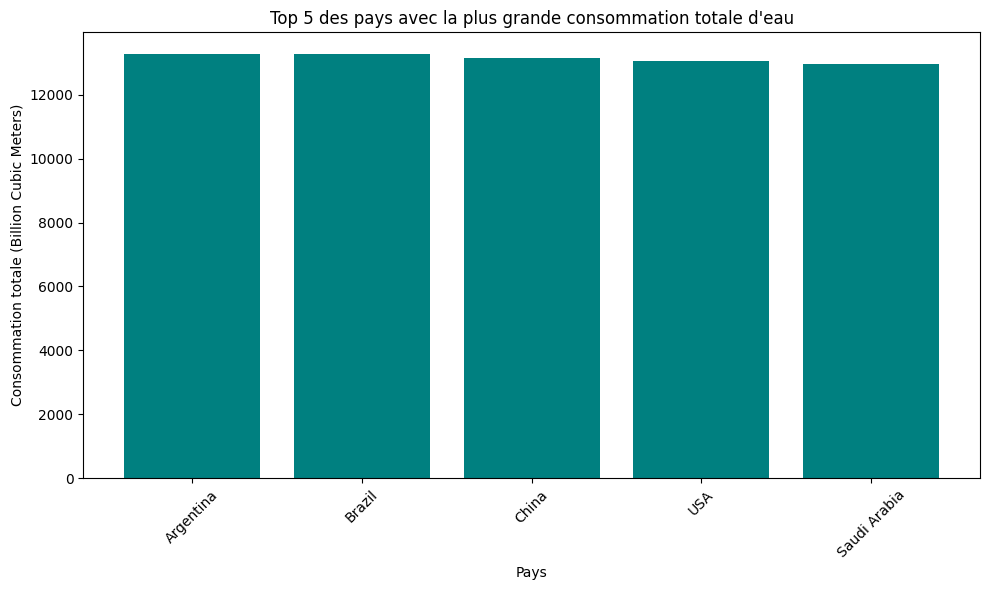

In [38]:
# Visualisation 1: Top 5 pays consommation totale
plt.figure(figsize=(10, 6))
plt.bar(top5_pd['Country'], top5_pd['Total_Consumption'], color='teal')
plt.title('Top 5 des pays avec la plus grande consommation totale d\'eau')
plt.xlabel('Pays')
plt.ylabel('Consommation totale (Billion Cubic Meters)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

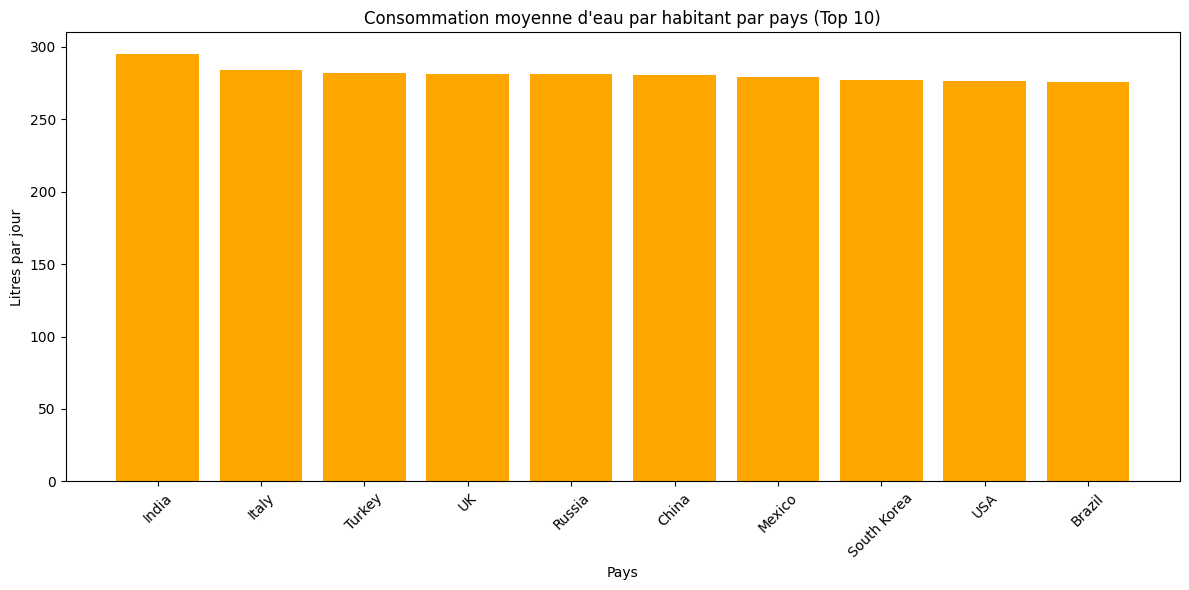

In [39]:
# Visualisation 2: Consommation moyenne par habitant
plt.figure(figsize=(12, 6))
plt.bar(avg_per_capita_pd['Country'], avg_per_capita_pd['Avg_Per_Capita'], color='orange')
plt.title('Consommation moyenne d\'eau par habitant par pays (Top 10)')
plt.xlabel('Pays')
plt.ylabel('Litres par jour')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

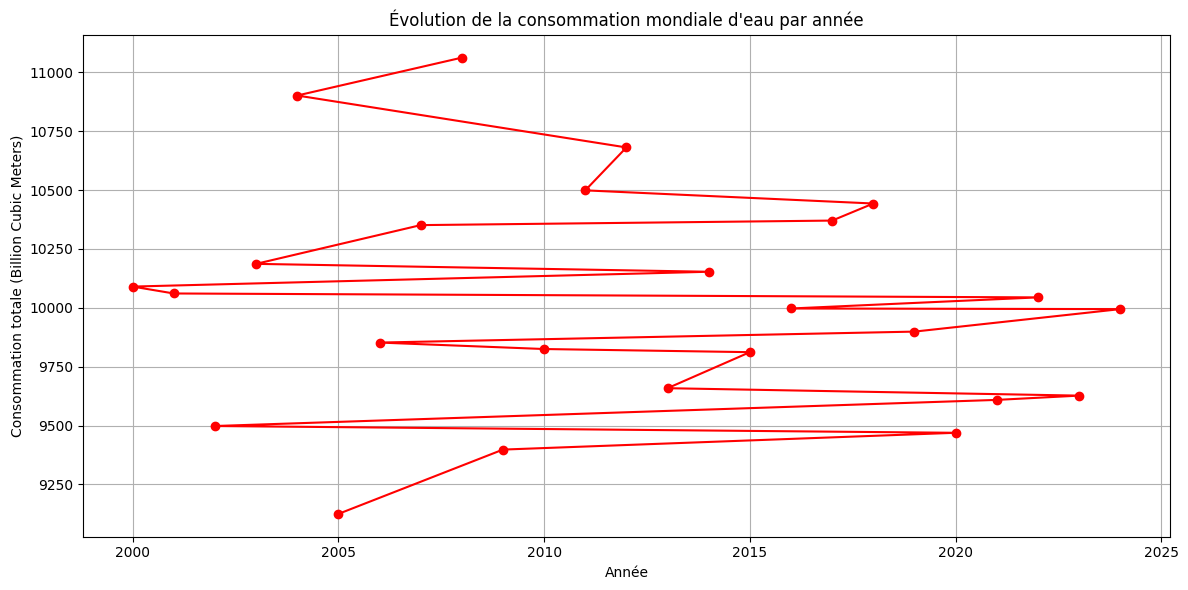

In [29]:
# Visualisation 3: Évolution de la consommation par année
plt.figure(figsize=(12, 6))
plt.plot(yearly_consumption_pd['Year'], yearly_consumption_pd['Global_Consumption'], 
         marker='o', linestyle='-', color='red')
plt.title('Évolution de la consommation mondiale d\'eau par année')
plt.xlabel('Année')
plt.ylabel('Consommation totale (Billion Cubic Meters)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
### Partie 4: Analyse des résultats

print("\nANALYSE DES RÉSULTATS:")
print("1. Les 5 pays avec la plus grande consommation totale d'eau sont:")
for row in top5_countries.collect():
    print(f"- {row['Country']}: {row['Total_Consumption']:.2f} BCM")

max_pc = max_per_capita.collect()[0]
print(f"\n2. Le pays avec la plus grande consommation par habitant est {max_pc['Country']} en {max_pc['Year']} avec {max_pc['Per_Capita_Water_Use']:.2f} litres/jour")

print(f"\n3. La consommation maximale a été enregistrée en {max_year['Year']} avec {max_year['Global_Consumption']:.2f} BCM")
print(f"   La consommation minimale a été enregistrée en {min_year['Year']} avec {min_year['Global_Consumption']:.2f} BCM")

print("\n4. Tendance générale:")
print("   La consommation mondiale d'eau montre des fluctuations annuelles mais semble globalement stable sur la période étudiée.")
print("   Certains pays comme les États-Unis, la Chine et l'Inde dominent la consommation totale.")
print("   Les pays arides ont tendance à avoir une consommation par habitant plus élevée.")

print("\n5. Facteurs explicatifs:")
print("   - Les précipitations influencent fortement la consommation agricole")
print("   - Le développement économique impacte la consommation industrielle")
print("   - Les politiques de gestion de l'eau expliquent les différences entre pays")
print("   - La croissance démographique est un facteur clé dans certains pays")



ANALYSE DES RÉSULTATS:
1. Les 5 pays avec la plus grande consommation totale d'eau sont:
- Argentina: 13284.86 BCM
- Brazil: 13263.29 BCM
- China: 13133.60 BCM
- USA: 13058.95 BCM
- Saudi Arabia: 12966.08 BCM

2. Le pays avec la plus grande consommation par habitant est India en 2000 avec 404.35 litres/jour

3. La consommation maximale a été enregistrée en 2008 avec 11062.78 BCM
   La consommation minimale a été enregistrée en 2005 avec 9124.76 BCM

4. Tendance générale:
   La consommation mondiale d'eau montre des fluctuations annuelles mais semble globalement stable sur la période étudiée.
   Certains pays comme les États-Unis, la Chine et l'Inde dominent la consommation totale.
   Les pays arides ont tendance à avoir une consommation par habitant plus élevée.

5. Facteurs explicatifs:
   - Les précipitations influencent fortement la consommation agricole
   - Le développement économique impacte la consommation industrielle
   - Les politiques de gestion de l'eau expliquent les diff

In [31]:
# Arrêt de la session Spark
spark.stop()